In [672]:
import numpy as np
import pandas as pd
import os
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

# Background:
- Lending Club will perform some level of verification on every borrower. As this verification process is happening investors can be funding portions of the loans. If the borrower passes verification the loan is approved for investors and will be issued to the borrower if fully funded. If the borrower fails verification the loan will not be issued. It will be deleted from the platform and all money that had been invested will be returned to the respective investors.
- A loan can stay on the platform for up to 14 days. Most loans are funded much quicker than that and once funded the loan will be deleted from the platform.

## Biz question 
- I set the biz question as trying to predict a defaulting loan at the time an investor can invest in it 
- the dataset has data only on post-invested loans, so inorder to a valid prediction we should avoid any fields (features) that are related only to post invested loan (to avoid temporal leak) a 
- The Fields that are available for an investor when he looks at an active loan (before it's issued, during the 14 day window):
from https://www.lendacademy.com/lending-club-review/                                                                                 

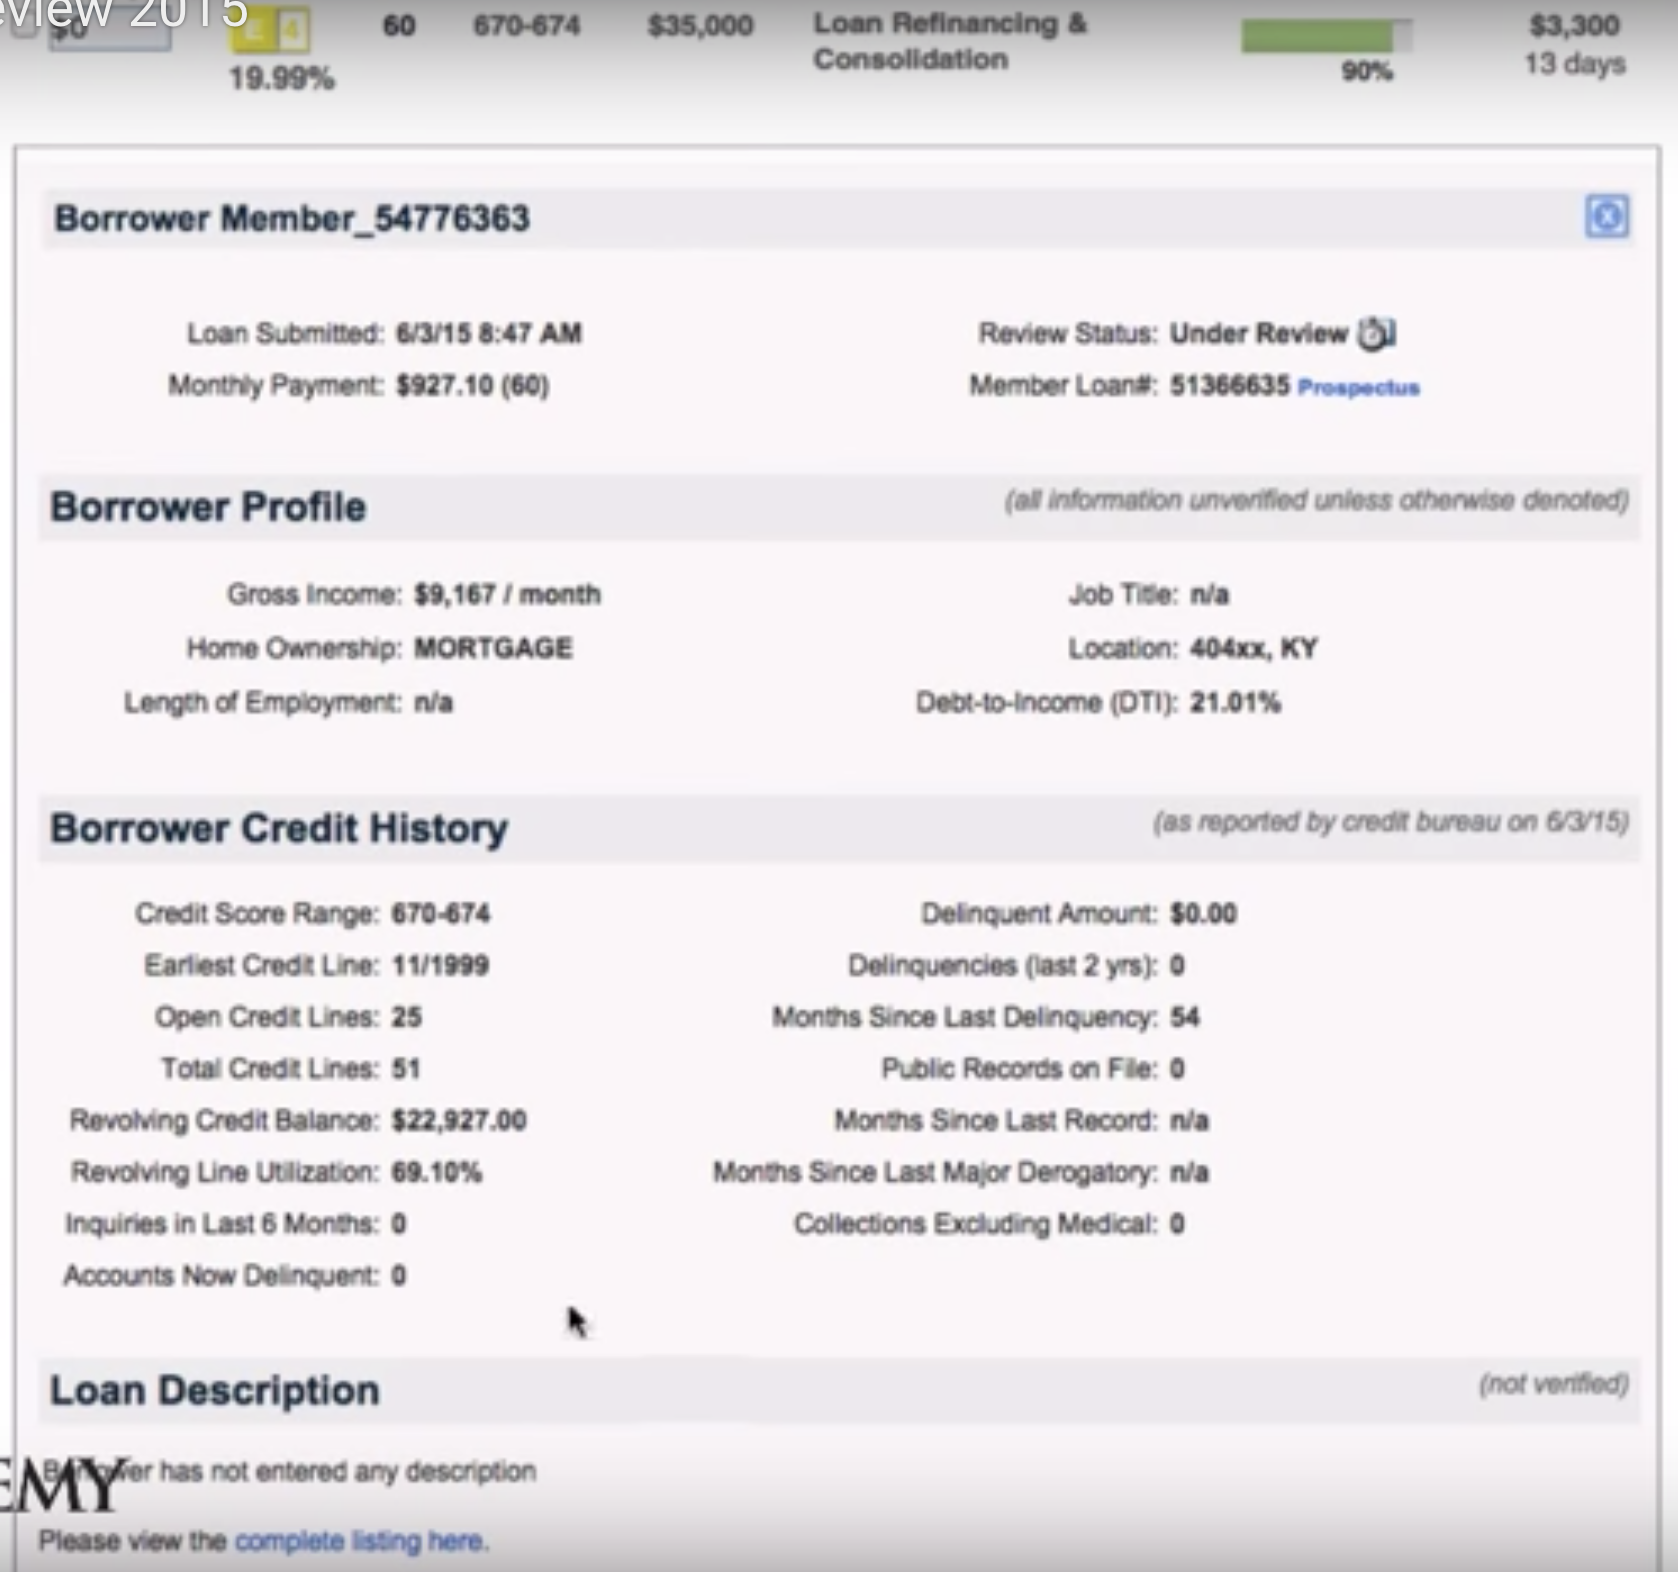

In [1182]:
raw=pd.read_csv('LoanStats3c.csv')
print(raw.shape)
raw.head(2)

(161231, 52)


/Users/eran/anaconda3/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2698: DtypeWarning: Columns (19) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


,id,member_id,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,sub_grade,...,total_rec_late_fee,recoveries,collection_recovery_fee,last_pymnt_d,last_pymnt_amnt,next_pymnt_d,last_credit_pull_d,collections_12_mths_ex_med,mths_since_last_major_derog,policy_code
0,29003494,31526675,28000,28000,28000,36 months,7.12%,866.10,A,A3,...,0.0,0.0,0.0,Nov-14,866.10,Nov-14,Oct-14,0,NaN,1
1,28913233,31436395,3000,3000,3000,36 months,11.67%,99.18,B,B4,...,0.0,0.0,0.0,Oct-14,99.18,Nov-14,Oct-14,0,NaN,1


In [1183]:
raw['loan_status'].value_counts()

Current               151208
Fully Paid              6922
Late (31-120 days)      1362
In Grace Period          853
Late (16-30 days)        409
Charged Off              400
Default                   76
Issued                     1
Name: loan_status, dtype: int64

#### Percent Projected to be charged off (by loan_status):
#### From : https://www.lendingclub.com/info/demand-and-credit-profile.action
            
- 22% of Grace Period
- 50% of late(16-30 days)
- 75% of late(31-120 days)
- 72% of Default 
#### seems that Default and Late have similar prospects. let's include " a bit late" in the fully paid group and the rest in the Default group 

In [1184]:
# creating 3 classes: Current = 2, Fully Paid = 0, Deafault =1
raw_lab=raw.copy() ## new df with labels
raw_lab['Loan_response']=raw_lab['loan_status'].apply(lambda x: 1 if (x=='Late (31-120 days)') or (x=='Charged Off') or (x=='Default') else (2 if (x=='Current') else 0))

In [1185]:
# The distribution of the loans into three classes:
raw_lab['Loan_response'].value_counts()

2    151208
0      8185
1      1838
Name: Loan_response, dtype: int64

### 3. let's start cleanning the data 
a. EDA on the features, research background

b. creating dummie features from selected categorical featuresn(e.g. 'term' variable)

c. Discarding un-informative features (e.g. 'id' feature)

d. Dealing with missing data 

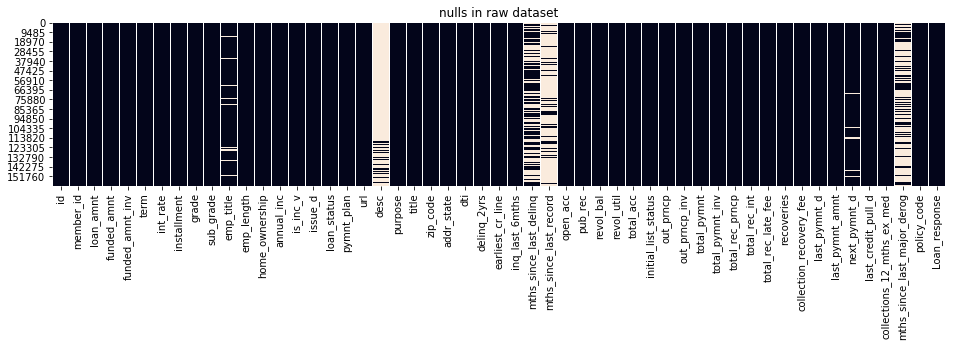

In [358]:
plt.subplots(figsize=(16,3))
sns.heatmap(raw_lab.isnull(),cbar=False)
iii=plt.title('nulls in raw dataset')

#### Features to drop/keep
- After LC online research, and using the dictionary given. the columns (fields) that should stay and ones that should be removed are given in the following summary I created:

In [1186]:
col_rel=pd.read_csv('/Users/eran/Desktop/Galvanize-Resources/innterview_Qs/ThetaRay_takehome/col_relevant.csv',)
col_rel=col_rel.iloc[:,0:2]
col_rel=list(col_rel.iloc[:,0][col_rel['0']==1])
col_rel ## list of the columns to keep

['annual_inc',
 'collections_12_mths_ex_med',
 'delinq_2yrs',
 'dti',
 'earliest_cr_line',
 'emp_length',
 'grade',
 'home_ownership',
 'inq_last_6mths',
 'installment',
 'int_rate',
 'is_inc_v',
 'loan_amnt',
 'mths_since_last_delinq',
 'mths_since_last_major_derog',
 'mths_since_last_record',
 'open_acc',
 'policy_code',
 'pub_rec',
 'purpose',
 'revol_bal',
 'revol_util',
 'sub_grade',
 'term',
 'title',
 'total_acc']

#### EDA - Hypothesis is that some of the 'current' class attributes might look more like 'fully paid' and some more like 'Default'. So we can Put emphasis on loans that we know that their final outcome was fully paid and some that where defaulted

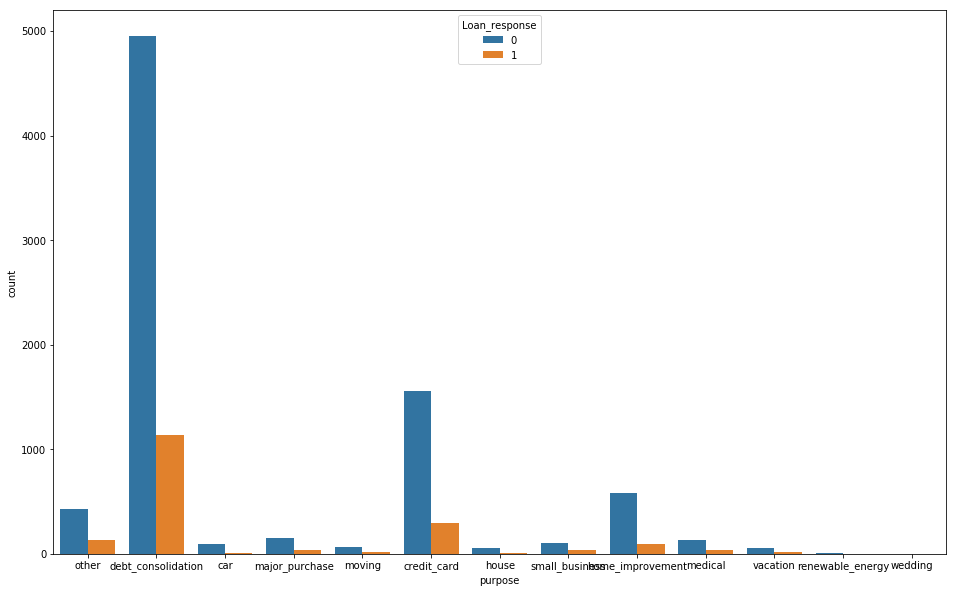

In [253]:
plt.subplots(figsize=(16,10))
raw_lab_0_1=raw_lab[raw_lab['Loan_response']!=2]
iii=sns.countplot('purpose',data=raw_lab_0_1,hue='Loan_response')

c. Discarding un-informative features (e.g. 'id' feature)

In [1187]:
# list of columns
raw_lab.columns

Index(['id', 'member_id', 'loan_amnt', 'funded_amnt', 'funded_amnt_inv',
       'term', 'int_rate', 'installment', 'grade', 'sub_grade', 'emp_title',
       'emp_length', 'home_ownership', 'annual_inc', 'is_inc_v', 'issue_d',
       'loan_status', 'pymnt_plan', 'url', 'desc', 'purpose', 'title',
       'zip_code', 'addr_state', 'dti', 'delinq_2yrs', 'earliest_cr_line',
       'inq_last_6mths', 'mths_since_last_delinq', 'mths_since_last_record',
       'open_acc', 'pub_rec', 'revol_bal', 'revol_util', 'total_acc',
       'initial_list_status', 'out_prncp', 'out_prncp_inv', 'total_pymnt',
       'total_pymnt_inv', 'total_rec_prncp', 'total_rec_int',
       'total_rec_late_fee', 'recoveries', 'collection_recovery_fee',
       'last_pymnt_d', 'last_pymnt_amnt', 'next_pymnt_d', 'last_credit_pull_d',
       'collections_12_mths_ex_med', 'mths_since_last_major_derog',
       'policy_code', 'Loan_response'],
      dtype='object')

In [1188]:
## Every row has a unique loan and is by a unique member. so we can drop these columns (even though there might be a change in id once the loan status changes?)
print('ids are unique:',len(raw_lab['id'].unique()), len(raw_lab['member_id'].unique()))

ids are unique: 161231 161231


In [1189]:
# interst rates are in strings, we should 'numerize' them 
raw_lab['int_rate']=raw_lab['int_rate'].apply(lambda x: x.rstrip('%'))
raw_lab['int_rate']=raw_lab['int_rate'].astype(float)

In [1190]:
# Changing the grades categories to ranked numerals: grade - (1-7) and sub_grade (1-35)
grade_let=raw_lab['grade'].value_counts().index.sort_values()
subgrade_let=raw_lab['sub_grade'].value_counts().index.sort_values()

def lettonum(letters):
    d={}    
    for ii,ob in enumerate(letters):
        d[ob]=ii+1
    return(d)

raw_lab['grade']=raw_lab['grade'].replace(lettonum(grade_let))
raw_lab['sub_grade']=raw_lab['sub_grade'].replace(lettonum(subgrade_let))

In [1191]:
raw_lab[['grade','sub_grade']][0:2]

,grade,sub_grade
0,1,3
1,2,9


In [1192]:
## If time allows, could feature engineer titles with NLP ('manager', 'principal', 'attorny', 'Doctor', 'Physician', 'VP') 
## in one group of high earners, and the rest in other earners.
## for now I will drop it
print('# of employment titles:',len(raw_lab['emp_title'].unique()))
raw_lab['emp_title'][0:3]

# of employment titles: 55439


0                 attorney
1    Eligibility Worker II
2       LABORATORY MANAGER
Name: emp_title, dtype: object

In [1193]:
## employement length feature - turnning into numerical (note >10 is converted to 15)
emp_num=raw_lab['emp_length'].value_counts().index.sort_values()
print(emp_num)
emp_dic={'1 year':1, '10+ years':15, '2 years':2, '3 years':3, '4 years':4, '5 years':5,
       '6 years':6, '7 years':7, '8 years':8, '9 years':9, '< 1 year':0.5, 'n/a':0}
raw_lab['emp_length']=raw_lab['emp_length'].replace(emp_dic)

Index(['1 year', '10+ years', '2 years', '3 years', '4 years', '5 years',
       '6 years', '7 years', '8 years', '9 years', '< 1 year', 'n/a'],
      dtype='object')


In [1194]:
one_dic={'ANY':'MORTGAGE'}
raw_lab['home_ownership']=raw_lab['home_ownership'].replace(one_dic)

In [1195]:
raw_lab['home_ownership'].value_counts()

MORTGAGE    83149
RENT        62752
OWN         15330
Name: home_ownership, dtype: int64

In [1196]:
## Payment plan is when a loan is already charged-off (should confirm), so it's possibly target-leaked
## should remove feature

In [1197]:
raw_lab['pymnt_plan'][raw_lab['Loan_response']==2].value_counts()

n    151204
y         4
Name: pymnt_plan, dtype: int64

In [1198]:
raw_lab['pymnt_plan'][raw_lab['Loan_response']==0].value_counts()

n    8183
y       2
Name: pymnt_plan, dtype: int64

In [1199]:
raw_lab['pymnt_plan'][raw_lab['Loan_response']==1].value_counts()

n    1832
y       6
Name: pymnt_plan, dtype: int64

In [1200]:
## merging wedding with other because of just 7 instances

In [1201]:
len(raw_lab[raw_lab['purpose']=='wedding'])

7

In [1202]:
len(raw_lab[(raw_lab['Loan_response']==2)&(raw_lab['purpose']=='wedding')])

6

In [1203]:
wed_dic={'wedding':'other'}
raw_lab['purpose']=raw_lab['purpose'].replace(wed_dic)

In [1204]:
## For NLP engineering, should go into if there is time. for now - drop
len(raw_lab['title'].unique())

2052

In [1205]:
#The number of open credit lines in the borrower's credit file.
raw_lab['open_acc'].describe()

count    161231.000000
mean         11.632620
std           5.175382
min           0.000000
25%           8.000000
50%          11.000000
75%          14.000000
max          76.000000
Name: open_acc, dtype: float64

In [1206]:
# ## Question - how to replace the nulls in 'mths_since_last_record' ? (same goes to 'mths_since_last_delinq' )
## null number too big (can not erase rows and 'mode', 'median' replacement might skew)
## 'mths_since_last_record' has:
## the same distribution in all classes (μ,σ,hist)
## the same ratio between nulls and numericals
## seems that there is no "information" in the feature
## but there is 2 apperant distributions: up to 24 months 'rec', and older 'old'
# turn: mths_since_last_record into 3 classes to later be dummie variables

raw_lab['mths_since_last_record.eng']=raw_lab['mths_since_last_record'].apply(lambda x: 'rec' if (x<25) else ('old' if x>24 else x))
raw_lab['mths_since_last_record.eng']=raw_lab['mths_since_last_record.eng'].replace(np.nan, 'NaN', regex=True)
raw_lab['mths_since_last_record.eng'].value_counts()


NaN    132302
old     27425
rec      1504
Name: mths_since_last_record.eng, dtype: int64

In [1207]:
sum(raw_lab['mths_since_last_delinq']==0)
sum(raw_lab['mths_since_last_delinq'].isnull())

80223

In [1208]:
#same with 'mths_since_last_delinq'
raw_lab['mths_since_last_delinq.eng']=raw_lab['mths_since_last_delinq'].apply(lambda x: 'rec' if (x<25)&(x>0) else ('old' if x>24 else x))
raw_lab['mths_since_last_delinq.eng']=raw_lab['mths_since_last_delinq.eng'].replace(np.nan, 'NaN', regex=True)
raw_lab['mths_since_last_delinq.eng'].replace(0,'NaN',inplace=True)
raw_lab['mths_since_last_delinq.eng'].value_counts()

NaN    80404
old    47253
rec    33574
Name: mths_since_last_delinq.eng, dtype: int64

In [1209]:
# raw_lab['pub_rec'].value_counts() - -OK

In [1210]:
#raw_lab['revol_bal'].describe() -- ok

In [1211]:
# 'revol_util' are % in strings, and have nulls we should 'numerize', and replace nulls with 'Mean' = 55
raw_lab['revol_util']=raw_lab['revol_util'].replace(np.nan,'55', regex=True)
raw_lab['revol_util']=raw_lab['revol_util'].apply(lambda x: x.rstrip('%'))
raw_lab['revol_util']=raw_lab['revol_util'].astype(float)

In [1212]:
## 'next_pymnt_d' - replace one instance of a date with one of the other dates (there are only 2)
## can dumify, or discard
raw_lab['next_pymnt_d']=raw_lab['next_pymnt_d'].replace('Oct-14', 'Nov-14', regex=True)

In [1213]:
# ## Question - how to replace the nulls in 'mths_since_last_major_derog.eng' ? (same goes to mths_since_last_record','mths_since_last_delinq' )
## null number too big (can not erase rows and 'mode', 'median' replacement might skew)
## # seems that class default have more recent major derogetory than class fully paid
# Current and fully paid are similar  
# the classes have:
## the same distribution in all classes (μ,σ,hist)
## the same ratio between nulls and numericals
## for now i divided it as up to 24 months 'rec', and older 'old'
# turn: mths_since_last_record into 3 classes to later be dummie variables

raw_lab['mths_since_last_major_derog.eng']=raw_lab['mths_since_last_major_derog'].apply(lambda x: 'rec' if (x<25) else ('old' if x>24 else x))
raw_lab['mths_since_last_major_derog.eng']=raw_lab['mths_since_last_major_derog.eng'].replace(np.nan, 'NaN', regex=True)
raw_lab['mths_since_last_major_derog.eng'].value_counts()


NaN    116056
old     34715
rec     10460
Name: mths_since_last_major_derog.eng, dtype: int64

'earliest_cr_line' should be engineered with 'issue_d' to create a new feature - the number of years a borrower has a credit line:

Borowers years of credit histogram


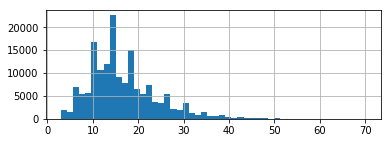

In [1331]:
plt.subplots(figsize=(6,2))
monyr=raw_lab['earliest_cr_line'].str.split('-',expand=True)
monyr=monyr.iloc[:,1].astype(float)
monyr=monyr.apply(lambda x: (2000+x) if x<15 else (1900+x))
monyr2=raw_lab['issue_d'].str.split('-',expand=True)
monyr2=monyr2.iloc[:,1].astype(float)
monyr2=monyr2.apply(lambda x: (2000+x) if x<15 else (1900+x))
credyrs=monyr2-monyr   
raw_lab['credit_yrs.eng']=credyrs
raw_lab['credit_yrs.eng'].hist(bins=50)
print('Borowers years of credit histogram')

### final steps of cleanning

In [1449]:
# let's save the following major changes in a new df - clean_df
clean_df=raw_lab.copy()

In [1450]:
## columns "to dummiefy"    
# turn to TRUE to run (only after collecting all the columns that need it)
if 1==1:
    dums=['home_ownership','term','is_inc_v','purpose','mths_since_last_record.eng',
          'mths_since_last_major_derog.eng','mths_since_last_delinq.eng','initial_list_status','next_pymnt_d']
    clean_df=pd.get_dummies(raw_lab,columns=dums,drop_first=False)
    #clean_df=pd.concat([clean_df, dums], axis=1)

In [1451]:
## the following columns are floats without missing data, (whether originally or ammended as such)    
col_float=['loan_amnt', 'funded_amnt', 'funded_amnt_inv','int_rate', 'installment',
         'grade','sub_grade','emp_length','annual_inc','delinq_2yrs','dti',
         'inq_last_6mths','open_acc','pub_rec','revol_bal','revol_util',
         'total_acc','out_prncp','out_prncp_inv','total_pymnt','total_pymnt_inv',
         'total_rec_prncp','total_rec_int','total_rec_late_fee','recoveries',
         'collection_recovery_fee','last_pymnt_amnt','collections_12_mths_ex_med']

In [1452]:
## Columns to drop:
if 1==1:
    col_drop=['id','member_id','emp_title','loan_status','url','desc','pymnt_plan',
              'title','mths_since_last_major_derog','mths_since_last_record','mths_since_last_delinq',
              'earliest_cr_line','next_pymnt_d_Dec-14','next_pymnt_d_Nov-14','credit_yrs']
    clean_df.drop(col_drop, inplace=True, axis=1)

In [1453]:
## confirming the list of cols to keep with 'col_rel'
print('columns not in "clean_df", not in "col_drop" and not in "dums":')
print('-------------------------------------------')
for col in col_rel:
    if col not in clean_df.columns:
        if col not in col_drop:
            if col not in dums:
                print(col)

columns not in "clean_df", not in "col_drop" and not in "dums":
-------------------------------------------


In [1454]:
## confirming the list of cols to keep with 'col_rel'
#print('columns in "clean_df" but not in "col_rel":')
print('-------------------------------------------')
col_drop2=[]
for col in clean_df:
    if col not in col_rel:
        col_drop2.append(col)         

-------------------------------------------


In [1455]:
# cols to finaly drop:
col_drop3=col_drop2[0:17]
col_drop3_leave_leak=col_drop3.copy()
col_drop3_leave_leak.remove('out_prncp')
len(col_drop3_leave_leak)

16

In [1456]:
## create df with a "leake" column, as a control df:
if 1==1:
    leaked_df=clean_df.copy()
    leaked_df.drop(col_drop3_leave_leak, inplace=True, axis=1)

In [1457]:
## create final df by droping columns:
if 1==1:
    clean_df.drop(col_drop3, inplace=True, axis=1)

In [1459]:
## this our final clean df:
leaked_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 161231 entries, 0 to 161230
Data columns (total 51 columns):
loan_amnt                              161231 non-null int64
int_rate                               161231 non-null float64
installment                            161231 non-null float64
grade                                  161231 non-null int64
sub_grade                              161231 non-null int64
emp_length                             161231 non-null float64
annual_inc                             161231 non-null float64
dti                                    161231 non-null float64
delinq_2yrs                            161231 non-null int64
inq_last_6mths                         161231 non-null int64
open_acc                               161231 non-null int64
pub_rec                                161231 non-null int64
revol_bal                              161231 non-null int64
revol_util                             161231 non-null float64
total_acc              

# End of notebook

# start of draft

# Modeling

In [948]:
'''importing models '''
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier

'''importing metrics '''
from sklearn.metrics import accuracy_score
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import roc_curve 
from sklearn.metrics import roc_auc_score
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import auc

#### Preparing train and test for "deafault" and "fully paid" classes

In [1484]:
## data set of only classes 0 and 1:
def split_01(df):
    ds_01=df[df['Loan_response']!=2]
    ds_2=df[df['Loan_response']==2]
    ## clean_df[clean_df['Loan_response']==1].shape = (1838, 63)
    print(ds_01.shape)
    return(ds_01)

In [1485]:
ds01f=split_01(leaked_df)
ds01v=split_01(clean_df)

(10023, 51)
(10023, 50)


In [1486]:
# remember to input ds01v for valid dataset or ds01f for leaked dataset:
ds01=ds01v
# splitiing train, test
X01_train, X01_test, y01_train, y01_test = train_test_split(ds01.drop('Loan_response',1),
                                                            ds01['Loan_response'], test_size=0.30, random_state=42)

In [1487]:
X01_train.shape, X01_test.shape, y01_train.shape, y01_test.shape

((7016, 49), (3007, 49), (7016,), (3007,))

#### preparing train and test for "current" class (for later use)

In [1363]:
## class 2 has ~ 150,000 obj, so let's subset a ~10,000 (i.e. "small") and leave the rest ~140,000 for later:
X2_small, X2_big, y2_small, y2_big = train_test_split(ds2.drop('Loan_response',1),
                                                            ds2['Loan_response'], test_size=0.93, random_state=42)

In [1364]:
X2_small.shape, X2_big.shape, y2_small.shape, y2_big.shape

((10584, 49), (140624, 49), (10584,), (140624,))

In [1365]:
## From here we can build the train and test set for class 2
X2_train, X2_test, y2_train, y2_test = train_test_split(X2_small,
                                                            y2_small, test_size=0.20, random_state=42)

In [1366]:
X2_train.shape, X2_test.shape, y2_train.shape, y2_test.shape

((8467, 49), (2117, 49), (8467,), (2117,))

In [1367]:
# final train and test sets:
X012_train=pd.concat([X01_train, X2_train], axis=0)
y012_train=pd.concat([y01_train, y2_train], axis=0)
X012_test=pd.concat([X01_test, X2_test], axis=0)
y012_test=pd.concat([y01_test, y2_test], axis=0)
print(X012_train.shape)
print(y012_train.shape)
print(X012_test.shape)
print(y012_test.shape)
y012_test.shape[0]/y012_train.shape[0]

(15483, 49)
(15483,)
(5124, 49)
(5124,)


0.33094361557837626

#### Instnatiate the model

In [1463]:
int_params={'n_estimators':500,'min_samples_split':4,'max_features':30,'max_depth':5}

rf_int=RandomForestClassifier(random_state=42,n_estimators=int_params['n_estimators'],
                             min_samples_split=int_params['min_samples_split'],
                             max_features=int_params['max_features'],
                             max_depth=int_params['max_depth'])

In [1488]:
rf_int.fit(X01_train,y01_train)
predy=rf_int.predict(X01_test)
predprob=rf_int.predict_proba(X01_test)
cm=confusion_matrix(predy,y01_test)
# fpr, tpr, thresholds = roc_curve(ytest, predprob[:,1])
# precision, recall, threshol=precision_recall_curve(ytest, predprob[:,1])

#### results for a dataset with a temporal-leaked feature 

In [1481]:
print(cm)
#print(classification_report(y01_test,predy))

[[2279  311]
 [ 169  248]]


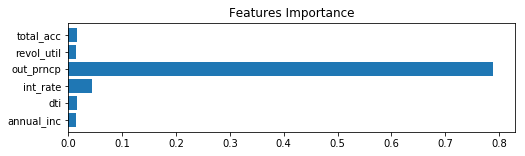

In [1482]:
most=rf_int.feature_importances_[rf_int.feature_importances_>0.015]
collnum=np.where(rf_int.feature_importances_>0.015)
colll=X01_train.columns[collnum]
plt.subplots(figsize=(8,2))
plt.barh(colll,most)
j=plt.title('Features Importance')

#### results for a clean and valid dataset

In [1489]:
print(cm)
#print(classification_report(y01_test,predy))

[[2448  559]
 [   0    0]]


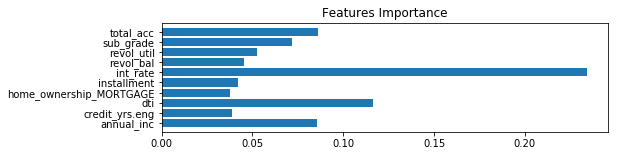

In [1497]:
most=rf_int.feature_importances_[rf_int.feature_importances_>0.035]
collnum=np.where(rf_int.feature_importances_>0.035)
colll=X01_train.columns[collnum]
plt.subplots(figsize=(8,2))
plt.barh(colll,most)
j=plt.title('Features Importance')

['int_rate', 'installment', 'sub_grade', 'annual_inc', 'dti', 'revol_bal', 'revol_util', 'total_acc', 'credit_yrs.eng', 'home_ownership_MORTGAGE']


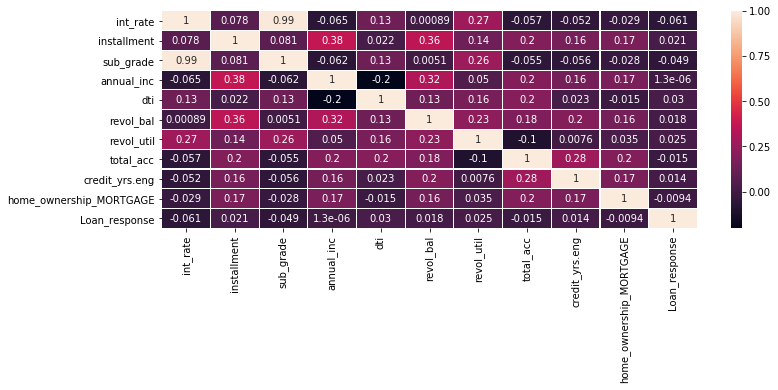

In [1499]:
plt.subplots(figsize=(12,4))
collname=list(X01_train.columns[collnum])
print(collname)
collname.append('Loan_response')
sns.heatmap(clean_df[collname].corr(),linewidths=.05,annot=True)

# Feature Engineering

# ---------------------------------

#### investigating a temporal/target leaked feature - 'out_prncp'

In [ ]:
# out_prncp - class=1 : median is 9304 (opposed to 0.0 in class=0), std much higher 

hist of "out_prncp" when ==0 or when >0. Note: ratio of count of classes(1:0:2)= 1 : 4.5 : 84


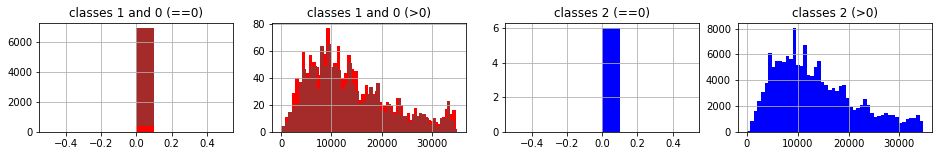

In [1054]:
plt.subplots(figsize=(16,2))
plt.subplot(1,4,1)
plt.title('classes 1 and 0 (==0)')
clean_df['out_prncp'][(clean_df['out_prncp']==0)&(clean_df['Loan_response']==0)].hist(bins=10,color='brown')
clean_df['out_prncp'][(clean_df['out_prncp']==0)&(clean_df['Loan_response']==1)].hist(bins=10,color='red')
plt.subplot(1,4,2)
plt.title('classes 1 and 0 (>0)')
clean_df['out_prncp'][(clean_df['out_prncp']>0)&(clean_df['Loan_response']==1)].hist(bins=50,color='red')
clean_df['out_prncp'][(clean_df['out_prncp']>0)&(clean_df['Loan_response']==0)].hist(bins=50,color='brown')
plt.subplot(1,4,3)
plt.title('classes 2 (==0)')
clean_df['out_prncp'][(clean_df['out_prncp']==0)&(clean_df['Loan_response']==2)].hist(bins=10,color='blue')
plt.subplot(1,4,4)
plt.title('classes 2 (>0)')
clean_df['out_prncp'][(clean_df['out_prncp']>0)&(clean_df['Loan_response']==2)].hist(bins=50,color='blue')
print('hist of "out_prncp" when ==0 or when >0. Note: ratio of count of classes(1:0:2)= 1 : 4.5 : 84' )

summary of leaked feature: 
- majority of default class have a "out_prncp". 
- majority of "current" have NO "out_prncp". 
- LOW number of fully paid have "out_prncp"

"out_prncp" means the remainder of the borowed amount that needs to be paid. naturaly, default group by definition still have to pay. whereas fully by definition have nothing left to pay (although we do see exceptions)   

# ---------------------------------

# ---------------------------------

# is column ok corner

### columns explored here: 'total_rec_late_fee' , 'recoveries'

In [ ]:
# 'total_rec_late_fee' most is 0. highly correlated to Default. should investigate the feature 
# column is clean, leave it as is for now, keep in "raw_lab" dataset

In [723]:
sum(raw_lab['total_rec_late_fee'].isnull())

0

In [ ]:
# 'recoveries' and 'collection_recovery_fee' are relating to the sa,e cell.most is 0. highly correlated to Default. should investigate the feature 
# column is clean, leave it as is for now, keep in "raw_lab" dataset

In [742]:
sum(raw_lab['recoveries'].isnull())

0

In [889]:
sum(raw_lab['last_pymnt_amnt'].isnull())

0

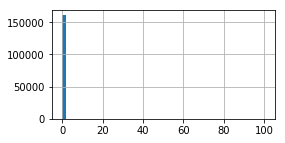

In [741]:
plt.subplots(figsize=(4,2))
raw_lab['total_rec_late_fee'].hist(bins=50)

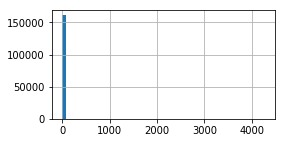

In [748]:
plt.subplots(figsize=(4,2))
raw_lab['recoveries'].hist(bins=50)

In [747]:
for ii in [0,1,2]:
    raw_lab['total_rec_late_fee'][raw_lab['Loan_response']==ii].value_counts()
    tt=sum(raw_lab['total_rec_late_fee'][raw_lab['Loan_response']==ii]>0)
    mm=len(raw_lab['total_rec_late_fee'][raw_lab['Loan_response']==ii])
    print(tt)
    print(mm)
    print('class:',ii,'tt/mm',tt/mm)

36
8185
class: 0 tt/mm 0.004398289554062309
75
1838
class: 1 tt/mm 0.040805223068552776
109
151208
class: 2 tt/mm 0.0007208613300883551


In [746]:
## all recovery fees are in the Default group possible - target leaked, should remove column
coll='recoveries'
for ii in [0,1,2]:
    raw_lab[coll][raw_lab['Loan_response']==ii].value_counts()
    tt=sum(raw_lab[coll][raw_lab['Loan_response']==ii]>0)
    mm=len(raw_lab[coll][raw_lab['Loan_response']==ii])
    print(tt)
    print(mm)
    print('class:',ii,'tt/mm',tt/mm)

0
8185
class: 0 tt/mm 0.0
6
1838
class: 1 tt/mm 0.003264417845484222
0
151208
class: 2 tt/mm 0.0


In [807]:
## all recovery fees are in the Default group possible - target leaked, should remove column
## 'collections_12_mths_ex_med' distribution looks similar, default is a bit different
coll='mths_since_last_major_derog'
for ii in [0,1,2]:
    raw_lab[coll][raw_lab['Loan_response']==ii].value_counts()
    tt=sum(raw_lab[coll][raw_lab['Loan_response']==ii]>0)
    mm=len(raw_lab[coll][raw_lab['Loan_response']==ii])
    print('class:',ii)
    print('e.g.:',raw_lab[coll][raw_lab['Loan_response']==ii].head(1))
    print('# nulls =',sum(raw_lab[coll][raw_lab['Loan_response']==ii].isnull()))
    print(raw_lab[coll][raw_lab['Loan_response']==ii].describe()[0:3])
    print(tt)
    print(mm)
    print('class:',ii,'tt/mm',np.round(tt/mm,3))
    print('-----------------------')
    

class: 0
e.g.: 100   NaN
Name: mths_since_last_major_derog, dtype: float64
# nulls = 5879
count    2306.000000
mean       43.386383
std        22.083403
Name: mths_since_last_major_derog, dtype: float64
2305
8185
class: 0 tt/mm 0.282
-----------------------
class: 1
e.g.: 4695    3.0
Name: mths_since_last_major_derog, dtype: float64
# nulls = 1312
count    526.000000
mean      40.908745
std       21.860842
Name: mths_since_last_major_derog, dtype: float64
526
1838
class: 1 tt/mm 0.286
-----------------------
class: 2
e.g.: 0   NaN
Name: mths_since_last_major_derog, dtype: float64
# nulls = 108865
count    42343.000000
mean        43.392721
std         22.160243
Name: mths_since_last_major_derog, dtype: float64
42302
151208
class: 2 tt/mm 0.28
-----------------------


# ---------------------------------

# ---------------------------------

# EDA "new"

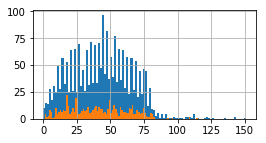

In [1507]:
# seems that class default have more recent major derogetory than class fully paid
# Current and fully paid are similar 
plt.subplots(figsize=(4,2))
efes=raw_lab[coll][raw_lab['Loan_response']==0]
ehad=raw_lab[coll][raw_lab['Loan_response']==1]
efes[efes.notnull()]
ehad[ehad.notnull()]
efes.hist(bins=100)
ehad.hist(bins=100)

# raw_lab[coll][raw_lab['Loan_response']==0]
# raw_lab[coll][raw_lab['Loan_response']==0].hist(bins=100)
# raw_lab[coll][raw_lab['Loan_response']==1].hist(bins=100)

In [1508]:
type(efes)
count, division = np.histogram(efes)

/Users/eran/anaconda3/lib/python3.6/site-packages/numpy/core/_methods.py:29: RuntimeWarning: invalid value encountered in reduce
  return umr_minimum(a, axis, None, out, keepdims)
/Users/eran/anaconda3/lib/python3.6/site-packages/numpy/core/_methods.py:26: RuntimeWarning: invalid value encountered in reduce
  return umr_maximum(a, axis, None, out, keepdims)


ValueError: range parameter must be finite.

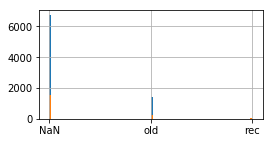

In [808]:
# seems that class default have more recent major derogetory than class fully paid
# Current and fully paid are similar 
plt.subplots(figsize=(4,2))
raw_lab['mths_since_last_major_derog.eng'][raw_lab['Loan_response']==0].hist(bins=100)
raw_lab['mths_since_last_major_derog.eng'][raw_lab['Loan_response']==1].hist(bins=100)

In [803]:
raw_lab[coll][raw_lab['Loan_response']==2].quantile(0.95)



77.0

In [722]:
raw_lab['total_rec_late_fee'][0:3]

0    0.0
1    0.0
2    0.0
Name: total_rec_late_fee, dtype: float64

In [776]:
raw_lab['next_pymnt_d'][0:3]

0    Nov-14
1    Nov-14
2    Nov-14
Name: next_pymnt_d, dtype: object

In [721]:
raw_lab['total_rec_late_fee'].describe()

count    161231.000000
mean          0.033618
std           1.034395
min           0.000000
25%           0.000000
50%           0.000000
75%           0.000000
max         100.380000
Name: total_rec_late_fee, dtype: float64

In [744]:
raw_lab['recoveries'].describe()

count    161231.000000
mean          0.060596
std          12.659022
min           0.000000
25%           0.000000
50%           0.000000
75%           0.000000
max        4278.150000
Name: recoveries, dtype: float64

In [791]:
raw_lab['mths_since_last_major_derog'].describe()

count    45175.000000
mean        43.363475
std         22.153984
min          0.000000
25%         26.000000
50%         43.000000
75%         60.000000
max        188.000000
Name: mths_since_last_major_derog, dtype: float64

# END of is column ok corner

In [384]:
raw_lab.columns

Index(['id', 'member_id', 'loan_amnt', 'funded_amnt', 'funded_amnt_inv',
       'term', 'int_rate', 'installment', 'grade', 'sub_grade', 'emp_title',
       'emp_length', 'home_ownership', 'annual_inc', 'is_inc_v', 'issue_d',
       'loan_status', 'pymnt_plan', 'url', 'desc', 'purpose', 'title',
       'zip_code', 'addr_state', 'dti', 'delinq_2yrs', 'earliest_cr_line',
       'inq_last_6mths', 'mths_since_last_delinq', 'mths_since_last_record',
       'open_acc', 'pub_rec', 'revol_bal', 'revol_util', 'total_acc',
       'initial_list_status', 'out_prncp', 'out_prncp_inv', 'total_pymnt',
       'total_pymnt_inv', 'total_rec_prncp', 'total_rec_int',
       'total_rec_late_fee', 'recoveries', 'collection_recovery_fee',
       'last_pymnt_d', 'last_pymnt_amnt', 'next_pymnt_d', 'last_credit_pull_d',
       'collections_12_mths_ex_med', 'mths_since_last_major_derog',
       'policy_code', 'Loan_response'],
      dtype='object')

# explorrrrrrrrrrrrrrrrrr

In [530]:
print(sum(raw_lab['delinq_2yrs'].isnull()))
raw_lab['delinq_2yrs'].value_counts()[0:6] 
# The number of 30+ days past-due incidences of delinquency in the borrower's credit file for the past 2 years

0


0    128076
1     21602
2      6687
3      2490
4      1087
5       576
Name: delinq_2yrs, dtype: int64

null_: 132302
tot_ 161231
null_/tot_: 0.8205742071934057
confirm null_all 132302
null0: 6691
tot0: 8185
null0/tot0: 0.8174709835064141
null1: 1544
tot1: 1838
null1/tot1: 0.8400435255712732
null2: 124067
tot2: 151208
null2/tot2: 0.8205055288079995
------------
count    1494.000000
mean       71.923025
std        28.179291
min         0.000000
25%        51.000000
50%        71.000000
75%       100.000000
max       119.000000
Name: mths_since_last_record, dtype: float64
count    294.000000
mean      73.602041
std       28.635072
min        2.000000
25%       55.000000
50%       75.000000
75%      100.000000
max      119.000000
Name: mths_since_last_record, dtype: float64


count    27141.000000
mean        71.498397
std         28.767588
min          1.000000
25%         50.000000
50%         70.000000
75%        100.000000
max        121.000000
Name: mths_since_last_record, dtype: float64

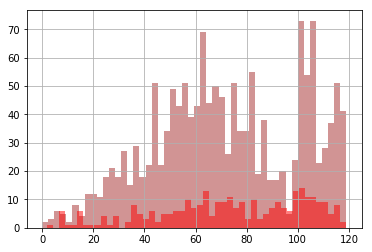

In [515]:
## Question - how to replace the nulls in 'mths_since_last_record' ? (same goes to 'mths_since_last_delinq' )
## null number too big (can not erase rows and 'mode', 'median' replacement might skew)
## 'mths_since_last_record' has:
## the same distribution in all classes (μ,σ,hist)
## the same ratio between nulls and numericals
## seems that there is no "information" in the feature
## option 1 replace nulls with median
## option 2 classify the feature into had_record=0,had_record=1 
## option 3 some transformation the the whole data with null as zero

# nulls ratio in all
null_=sum(raw_lab['mths_since_last_record'].isnull())
print('null_:',null_)
tot_=len(raw_lab)
print('tot_',tot_)
print('null_/tot_:',null_/tot_)
nullsall=null2+null1+null0
print('confirm null_all',nullsall)

# nulls ratio in Fully paid
null0=sum(raw_lab['mths_since_last_record'][raw_lab['Loan_response']==0].isnull())
print('null0:',null0)
tot0=sum(raw_lab['Loan_response']==0)
print('tot0:',tot0)
print('null0/tot0:',null0/tot0)

# nulls ratio in default
null1=sum(raw_lab['mths_since_last_record'][raw_lab['Loan_response']==1].isnull())
print('null1:',null1)
tot1=sum(raw_lab['Loan_response']==1)
print('tot1:',tot1)
print('null1/tot1:',null1/tot1)

# nulls ratio in Current
null2=sum(raw_lab['mths_since_last_record'][raw_lab['Loan_response']==2].isnull())
print('null2:',null2)
tot2=sum(raw_lab['Loan_response']==2)
print('tot2:',tot2)
print('null2/tot2:',null2/tot2)
print('------------')
raw_lab['mths_since_last_record'][raw_lab['Loan_response']==0].hist(bins=50,alpha=0.5,color='brown',label='Fully_paid')
ii=raw_lab['mths_since_last_record'][raw_lab['Loan_response']==1].hist(bins=50,alpha=0.5,color='red',label='Default')
#raw_lab['mths_since_last_record'][raw_lab['Loan_response']==2].hist(bins=100,alpha=0.5,color='blue',label='Current')
print(notnul[raw_lab['Loan_response']==0].describe())
print(notnul[raw_lab['Loan_response']==1].describe())
notnul[raw_lab['Loan_response']==2].describe()

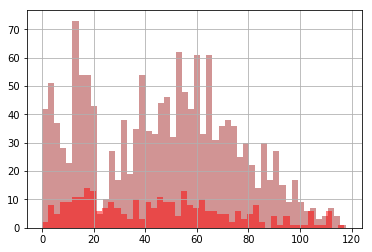

In [521]:
## option 3 some transformation the 'mths_since_last_record'feature with null as zero
## let's call it last record relevance from loww to high
raw_lab['mths_since_last_record'][raw_lab['Loan_response']==0].apply(lambda x: 2 if (x<24) & (x>0) else 60).hist(bins=50,alpha=0.5,color='brown',label='Fully_paid')
ii=raw_lab['mths_since_last_record'][raw_lab['Loan_response']==1].apply(lambda x: 0 if x==0 else -x+119).hist(bins=50,alpha=0.5,color='red',label='Default')
#

count    4074.000000
mean       33.554492
std        21.932123
min         0.000000
25%        15.000000
50%        31.000000
75%        50.000000
max       151.000000
Name: mths_since_last_delinq, dtype: float64
count    917.000000
mean      31.407852
std       21.854857
min        0.000000
25%       13.000000
50%       26.000000
75%       48.000000
max       82.000000
Name: mths_since_last_delinq, dtype: float64
count    76017.000000
mean        33.454925
std         21.861796
min          0.000000
25%         15.000000
50%         30.000000
75%         49.000000
max        188.000000
Name: mths_since_last_delinq, dtype: float64


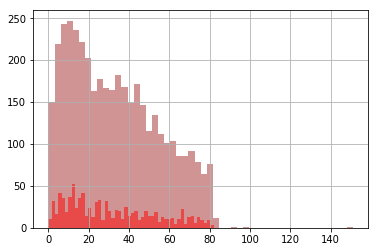

In [527]:
## Question - how to replace the nulls in 'mths_since_last_delinq' ? 
## default group seems to have longer time since last delinq 
## 
raw_lab['mths_since_last_delinq'][raw_lab['Loan_response']==0].hist(bins=50,alpha=0.5,color='blue',label='Fully_paid')
ii=raw_lab['mths_since_last_delinq'][raw_lab['Loan_response']==1].hist(bins=50,alpha=0.5,color='cyan',label='Default')
#raw_lab['mths_since_last_record'][raw_lab['Loan_response']==2].hist(bins=100,alpha=0.5,color='blue',label='Current')
print(raw_lab['mths_since_last_delinq'][raw_lab['mths_since_last_delinq'].notnull()][raw_lab['Loan_response']==0].describe())
print(raw_lab['mths_since_last_delinq'][raw_lab['mths_since_last_delinq'].notnull()][raw_lab['Loan_response']==1].describe())
print(raw_lab['mths_since_last_delinq'][raw_lab['mths_since_last_delinq'].notnull()][raw_lab['Loan_response']==2].describe())


# End of explorrrrrrrrrrrrrrrrrr

In [898]:
col_prob

['last_pymnt_d',
 'last_credit_pull_d',
 'earliest_cr_line',
 'issue_d',
 'zip_code',
 'addr_state']

## features not sure (to investigate further)

### columns unsure how to use (could not stay in dataset as is)
- dates: 'issue_d','earliest_cr_line','last_pymnt_d','next_pymnt_d','last_credit_pull_d'
- location: 'zip_code','addr_state'
- credit specific: 'total_rec_late_fee','recoveries','collection_recovery_fee','last_pymnt_amnt','collections_12_mths_ex_med'

In [ ]:
## probably informative, zip code is just 3 digits (so low resoulution) should engineer with longitude latitude converter or/and to 
## enrich with census (translate zip to socio-economic level of neighborhood) *  - for the next data scientist: 
## for now, drop

In [1089]:
raw.columns

Index(['id', 'member_id', 'loan_amnt', 'funded_amnt', 'funded_amnt_inv',
       'term', 'int_rate', 'installment', 'grade', 'sub_grade', 'emp_title',
       'emp_length', 'home_ownership', 'annual_inc', 'is_inc_v', 'issue_d',
       'loan_status', 'pymnt_plan', 'url', 'desc', 'purpose', 'title',
       'zip_code', 'addr_state', 'dti', 'delinq_2yrs', 'earliest_cr_line',
       'inq_last_6mths', 'mths_since_last_delinq', 'mths_since_last_record',
       'open_acc', 'pub_rec', 'revol_bal', 'revol_util', 'total_acc',
       'initial_list_status', 'out_prncp', 'out_prncp_inv', 'total_pymnt',
       'total_pymnt_inv', 'total_rec_prncp', 'total_rec_int',
       'total_rec_late_fee', 'recoveries', 'collection_recovery_fee',
       'last_pymnt_d', 'last_pymnt_amnt', 'next_pymnt_d', 'last_credit_pull_d',
       'collections_12_mths_ex_med', 'mths_since_last_major_derog',
       'policy_code'],
      dtype='object')

In [1090]:
raw_lab[['initial_list_status']].head()

,initial_list_status
0,w
1,w
2,f
3,f
4,w


In [446]:
raw_lab['zip_code'][0]

'331xx'

In [447]:
## zip should be better, state can categorize by poor, avg and rich states  
# - probably drop for now
len(raw_lab['addr_state'].unique())

49

0.4975656046293827
0     NaN
1     NaN
2    27.0
Name: mths_since_last_delinq, dtype: float64
count    4074.000000
mean       33.554492
std        21.932123
min         0.000000
25%        15.000000
50%        31.000000
75%        50.000000
max       151.000000
Name: mths_since_last_delinq, dtype: float64


count    917.000000
mean      31.407852
std       21.854857
min        0.000000
25%       13.000000
50%       26.000000
75%       48.000000
max       82.000000
Name: mths_since_last_delinq, dtype: float64

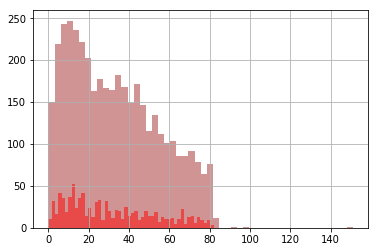

In [490]:
print(sum(raw_lab['mths_since_last_delinq'].isnull())/len(raw_lab))
notnul=raw_lab['mths_since_last_delinq'][raw_lab['mths_since_last_delinq'].notnull()]
print(raw_lab['mths_since_last_delinq'][0:3])
raw_lab['mths_since_last_delinq'][raw_lab['Loan_response']==0].hist(bins=50,alpha=0.5,color='brown',label='Fully_paid')
ii=raw_lab['mths_since_last_delinq'][raw_lab['Loan_response']==1].hist(bins=50,alpha=0.5,color='red',label='Default')
#raw_lab['mths_since_last_delinq'][raw_lab['Loan_response']==2].hist(bins=100,alpha=0.5,color='blue',label='Current')
print(notnul[raw_lab['Loan_response']==0].describe())
notnul[raw_lab['Loan_response']==1].describe()


### after background research:
### keep these columns:

In [1085]:
# drop these columns:
col_keep_research=['inq_last_6mths']  ## available to see for new investor, the lower should be better 
col_keep_research.append('loan_amnt') ## available to see, 'funded_amnt_inv' and 'funded_amnt' are almost the same so should discard them
col_keep_research.append('mths_since_last_delinq')
col_keep_research.append('mths_since_last_major_derog')
col_keep_research.append('collections_12_mths_ex_med') ## because medical collections everyone has (literature says there is no proved relationship with default)
col_keep_research.append('installment') ## The monthly payment for the loan (known before it's issued)

col_keep_research

['inq_last_6mths',
 'loan_amnt',
 'mths_since_last_delinq',
 'mths_since_last_major_derog',
 'collections_12_mths_ex_med',
 'installment']

### after background research:
### drop these columns:

In [ ]:
# drop these columns:
col_drop_research=['issued_d','earliest_cr_line','funded_amnt_inv','funded_amnt']

### explanations given here:

#### 'funded_amnt_inv', 'funded_amnt'

funded amounts for 10% of the loans are not completed entirely by investors
and they are from all year round
but they are around 99% funded, so no info there
also there is no relationship between that and classes


May-14    3073
Jan-14    2613
Feb-14    2204
Apr-14    1899
Mar-14    1675
Jun-14    1001
Jul-14     956
Aug-14     912
Sep-14     459
Name: issue_d, dtype: int64

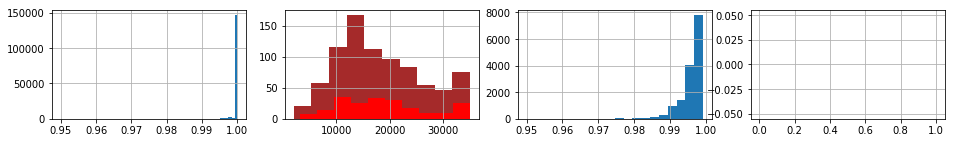

In [1084]:
plt.subplots(figsize=(16,2))
plt.subplot(1,4,1)
d=raw_lab['funded_amnt_inv']/raw_lab['funded_amnt']
d.hist(bins=100)
print('funded amounts for 10% of the loans are not completed entirely by investors')
print('and they are from all year round')
print('but they are around 99% funded, so no info there')
print('also there is no relationship between that and classes')
plt.subplot(1,4,2)
raw_lab['funded_amnt'][raw_lab['funded_amnt_inv']!=raw_lab['funded_amnt']][raw_lab['Loan_response']==0].hist(color='brown')
raw_lab['funded_amnt'][raw_lab['funded_amnt_inv']!=raw_lab['funded_amnt']][raw_lab['Loan_response']==1].hist(color='red')
plt.subplot(1,4,3)
d[d!=1].hist(bins=20)
plt.subplot(1,4,4)
raw_lab['loan_amnt'][raw_lab['loan_amnt']!=raw_lab['funded_amnt']][raw_lab['Loan_response']==0].hist(color='brown')
raw_lab['loan_amnt'][raw_lab['loan_amnt']!=raw_lab['funded_amnt']][raw_lab['Loan_response']==1].hist(color='red')

raw_lab['issue_d'][raw_lab['funded_amnt_inv']!=raw_lab['funded_amnt']].value_counts()

#### earliest credit line
- engineer as follows: 'issued_d' - 'earliest_cr_line' = months of actively having credit

In [456]:
raw_lab['earliest_cr_line'].value_counts()[8:16]

Oct-01    1082
Nov-99    1075
Oct-99    1068
Sep-02    1061
Nov-00    1034
Sep-98    1026
Mar-01    1010
Oct-02    1002
Name: earliest_cr_line, dtype: int64

#### issued_d
- loans have more chances to be defaulted or fully paid, when they pass enough time (hence ) the distribution
- could be valuable for current, but not for fully paid and default. discard

In [1057]:
raw_lab['issue_d'][raw_lab['Loan_response']==1].value_counts()

Jan-14    423
Feb-14    334
Mar-14    319
Apr-14    285
May-14    199
Jun-14    126
Jul-14    104
Aug-14     41
Sep-14      7
Name: issue_d, dtype: int64

In [1058]:
raw_lab['issue_d'][raw_lab['Loan_response']==0].value_counts()

Jan-14    1548
Feb-14    1237
Apr-14    1172
Mar-14    1166
May-14     974
Jul-14     914
Jun-14     695
Aug-14     340
Sep-14     139
Name: issue_d, dtype: int64

In [381]:
raw_lab['issue_d'][raw_lab['Loan_response']==2].value_counts()

Jul-14    28288
Aug-14    18433
May-14    17926
Apr-14    17614
Jun-14    16358
Mar-14    15028
Jan-14    13657
Feb-14    13444
Sep-14    10460
Name: issue_d, dtype: int64

In [382]:
raw_lab['last_pymnt_d'].value_counts()

Oct-14    111632
Nov-14     42102
Sep-14      2089
Aug-14      1642
Jul-14      1288
Jun-14       955
May-14       590
Apr-14       416
Mar-14       270
Feb-14       136
Name: last_pymnt_d, dtype: int64

In [780]:
raw_lab['last_credit_pull_d'].value_counts()

Oct-14    154769
Nov-14      1930
Sep-14      1388
Aug-14      1015
Jul-14       824
Jun-14       459
May-14       348
Apr-14       228
Mar-14       160
Feb-14        82
Jan-14        14
Dec-13         1
Name: last_credit_pull_d, dtype: int64

## End of months  - to investigate further
## #################################

## EDA draft 

In [151]:
raw['url'][0]

'https://www.lendingclub.com/browse/loanDetail.action?loan_id=29003494'

In [158]:
raw['annual_inc'].quantile(0.9)

125000.0

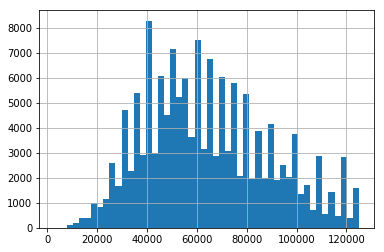

In [166]:
raw['annual_inc'][raw['annual_inc']<125001].hist(bins=50)

In [165]:
raw_lowinc=raw[raw['annual_inc']<125001]
raw_lowinc_lab=raw_lowinc[raw_lowinc['loan_status']!='Current']
raw_lowinc_lab['loan_status'].value_counts()

Fully Paid            6283
Late (31-120 days)    1274
In Grace Period        756
Late (16-30 days)      382
Charged Off            365
Default                 71
Issued                   1
Name: loan_status, dtype: int64

In [37]:
rawlog=raw.copy()
rawlog['annual_inc_log']=np.log10(rawlog['annual_inc'])

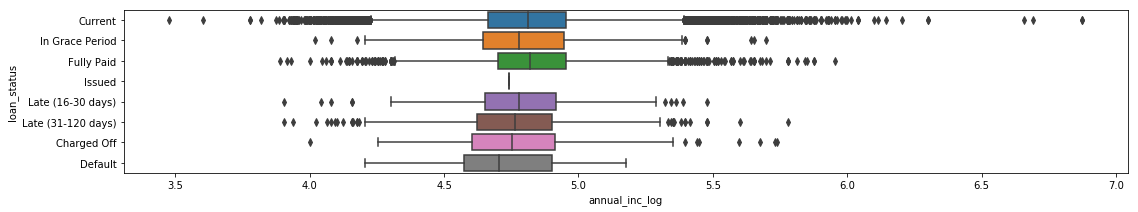

In [66]:
plt.subplots(figsize=(18,3))
iii=sns.boxplot('annual_inc_log','loan_status',data=rawlog)#hue='WnvPresent')

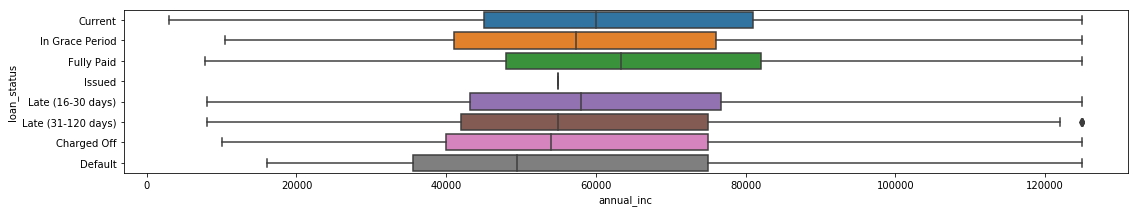

In [167]:
plt.subplots(figsize=(18,3))
iii=sns.boxplot('annual_inc','loan_status',data=raw_lowinc)#hue='WnvPresent')

#### Note the difference in income in the charged-off and default groups (both in log-income and truncated-income. Although Charged off is regarded more severe than default, it seems that in that group there are people with higher income and some with really high. Possible explanation maybe - they can afford to be charged-off ( able to pay   

In [64]:
print('number of "unlabeled" loans:')
len(raw['loan_status'][raw['loan_status']=='Current'])

number of "unlabeled" loans:


151208

In [80]:
lab_raw=raw[raw['loan_status']!='Current']
lab_rawlog=rawlog[rawlog['loan_status']!='Current']
lab_raw['loan_status'].value_counts()

Fully Paid            6922
Late (31-120 days)    1362
In Grace Period        853
Late (16-30 days)      409
Charged Off            400
Default                 76
Issued                   1
Name: loan_status, dtype: int64

In [176]:
unlab_raw=raw.copy()
unlab_raw=unlab_raw[unlab_raw['loan_status']=='Current']

In [212]:
unlab_raw.iloc[:,10:20].head()

,emp_title,emp_length,home_ownership,annual_inc,is_inc_v,issue_d,loan_status,pymnt_plan,url,desc
0,attorney,5 years,MORTGAGE,324388.0,Verified,Sep-14,Current,n,https://www.lendingclub.com/browse/loanDetail....,NaN
1,Eligibility Worker II,6 years,MORTGAGE,41500.0,Not Verified,Sep-14,Current,n,https://www.lendingclub.com/browse/loanDetail....,NaN
2,LABORATORY MANAGER,8 years,MORTGAGE,165000.0,Verified,Sep-14,Current,n,https://www.lendingclub.com/browse/loanDetail....,NaN
3,Housing Counselor,1 year,RENT,67000.0,Source Verified,Sep-14,Current,n,https://www.lendingclub.com/browse/loanDetail....,NaN
4,Process Improvement Officer,7 years,MORTGAGE,54264.0,Not Verified,Sep-14,Current,n,https://www.lendingclub.com/browse/loanDetail....,NaN


In [220]:
lab_raw['pymnt_plan'].value_counts()
lab_raw['is_inc_v'].value_counts()

lab_raw.shape

(10023, 52)

In [178]:
lab_raw.describe()

,id,member_id,loan_amnt,funded_amnt,funded_amnt_inv,installment,annual_inc,dti,delinq_2yrs,inq_last_6mths,...,total_pymnt_inv,total_rec_prncp,total_rec_int,total_rec_late_fee,recoveries,collection_recovery_fee,last_pymnt_amnt,collections_12_mths_ex_med,mths_since_last_major_derog,policy_code
count,1.002300e+04,1.002300e+04,10023.000000,10023.000000,10023.000000,10023.000000,10023.000000,10023.000000,10023.000000,10023.000000,...,10023.000000,10023.000000,10023.000000,10023.000000,10023.000000,10023.000000,10023.000000,10023.000000,2832.000000,10023.0
mean,1.444483e+07,1.633209e+07,13997.660381,13997.660381,13991.863713,427.864681,74576.868411,16.928708,0.346304,1.036516,...,10460.709320,9786.268455,677.595646,0.261897,0.974749,0.009747,8746.906754,0.011873,42.926201,1.0
std,4.033644e+06,4.344404e+06,8329.298935,8329.298935,8325.766950,246.968800,48264.343910,7.675324,0.906802,1.190775,...,9207.547251,8989.491467,699.866460,2.787428,50.765752,0.507658,8790.792755,0.113711,22.059452,0.0
min,6.781060e+05,8.663560e+05,1000.000000,1000.000000,1000.000000,30.710000,7740.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.0
25%,1.144587e+07,1.333904e+07,7575.000000,7575.000000,7575.000000,251.265000,47000.000000,11.180000,0.000000,0.000000,...,2529.405000,1500.000000,203.580000,0.000000,0.000000,0.000000,579.655000,0.000000,25.000000,1.0
50%,1.304638e+07,1.503876e+07,12000.000000,12000.000000,12000.000000,371.400000,65000.000000,16.680000,0.000000,1.000000,...,8189.400000,8000.000000,444.400000,0.000000,0.000000,0.000000,6626.270000,0.000000,43.000000,1.0
75%,1.648268e+07,1.853403e+07,19200.000000,19200.000000,19175.000000,554.100000,88215.000000,22.645000,0.000000,2.000000,...,15720.080000,15000.000000,901.215000,0.000000,0.000000,0.000000,14064.260000,0.000000,59.000000,1.0
max,2.825207e+07,3.076520e+07,35000.000000,35000.000000,35000.000000,1408.130000,900000.000000,39.750000,18.000000,6.000000,...,40380.500000,35000.000000,5439.260000,93.580000,4278.150000,42.781500,35757.360000,2.000000,151.000000,1.0


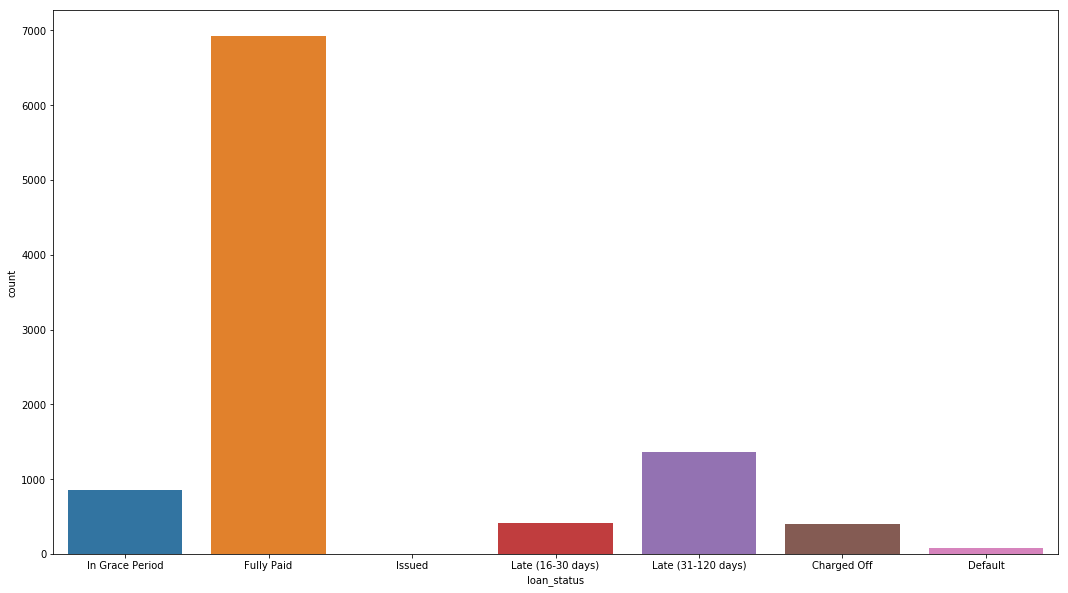

In [69]:
plt.subplots(figsize=(18,10))
iii=sns.countplot(lab_raw['loan_status'])

In [ ]:
### potentialy important features:
- delinq_2yrs: The number of 30+ days past-due incidences of delinquency in the borrower's credit file for the past 2 years
- dti: A ratio calculated using the borrower’s total monthly debt payments on the total debt obligations, excluding mortgage and the requested LC loan, divided by the borrower’s self-reported monthly income.
- grade	LC assigned loan grade
- Term - The number of payments on the loan. Values are in months and can be either 36 or 60.
- total_acc	The total number of credit lines currently in the borrower's credit file
- total_pymnt	Payments received to date for total amount funded
- total_pymnt_inv	Payments received to date for portion of total amount funded by investors!
additional points 
Interst The interest is derived from credit score

In [98]:
# also 'mths_since_last_delinq' but gives error in pairplot
imp_feat=['delinq_2yrs','annual_inc_log','annual_inc','dti','home_ownership','term','total_acc','loan_status']

In [99]:
lab_rawlog_impfeat=lab_rawlog[imp_feat]

In [100]:
lab_rawlog_impfeat.head()

,delinq_2yrs,annual_inc_log,dti,home_ownership,term,total_acc,loan_status
100,0,4.397940,24.92,RENT,36 months,15,In Grace Period
252,1,4.934498,20.03,MORTGAGE,36 months,55,Fully Paid
254,0,4.740363,13.57,MORTGAGE,60 months,22,Issued
490,0,4.776236,21.33,MORTGAGE,60 months,29,Fully Paid
631,1,5.113930,7.07,MORTGAGE,36 months,21,Fully Paid


In [118]:
lab_rawlog_impfeat_2=lab_rawlog_impfeat.copy()
lab_rawlog_impfeat_2['loan_status_2']=loan_status_2['loan_status'].apply(lambda x: 1 if (x=='Late (31-120 days)') or (x=='Late (16-30 days)') or (x=='Charged Off') or (x=='Default') else 0)

In [127]:
# Inclusion of a bit late in the 'OK' group
lab_rawlog_impfeat_2_risk=lab_rawlog_impfeat.copy()
lab_rawlog_impfeat_2_risk['loan_status_2']=loan_status_2['loan_status'].apply(lambda x: 1 if (x=='Late (31-120 days)') or (x=='Charged Off') or (x=='Default') else 0)

In [168]:
print(lab_rawlog_impfeat_2['loan_status_2'].value_counts())
print(lab_rawlog_impfeat_2_risk['loan_status_2'].value_counts())
lab_rawlog_impfeat_2.tail()

0    7776
1    2247
Name: loan_status_2, dtype: int64
0    8185
1    1838
Name: loan_status_2, dtype: int64


,delinq_2yrs,annual_inc_log,dti,home_ownership,term,total_acc,loan_status,loan_status_2
161198,1,4.653213,18.69,MORTGAGE,36 months,29,Late (31-120 days),1
161200,1,4.658965,1.50,MORTGAGE,60 months,13,Charged Off,1
161210,1,4.812913,11.26,MORTGAGE,36 months,26,Fully Paid,0
161221,4,4.574448,12.28,MORTGAGE,60 months,26,Charged Off,1
161227,0,4.892095,18.45,MORTGAGE,60 months,30,Late (31-120 days),1


In [169]:
lab_rawlog_dum=lab_rawlog_impfeat_2.copy()
lab_rawlog_dum_risk=lab_rawlog_impfeat_2_risk.copy()

In [170]:
lab_rawlog_dum=pd.get_dummies(lab_rawlog_dum,columns=['home_ownership','term'],drop_first=True)
lab_rawlog_dum_risk=pd.get_dummies(lab_rawlog_dum_risk,columns=['home_ownership','term'],drop_first=True)

In [123]:
lab_rawlog_dum.head()

,delinq_2yrs,annual_inc_log,dti,total_acc,loan_status,loan_status_2,home_ownership_MORTGAGE,home_ownership_OWN,home_ownership_RENT,term_ 60 months
100,0,4.397940,24.92,15,In Grace Period,0,0,0,1,0
252,1,4.934498,20.03,55,Fully Paid,0,1,0,0,0
254,0,4.740363,13.57,22,Issued,0,1,0,0,1
490,0,4.776236,21.33,29,Fully Paid,0,1,0,0,1
631,1,5.113930,7.07,21,Fully Paid,0,1,0,0,0


/Users/eran/anaconda3/lib/python3.6/site-packages/statsmodels/nonparametric/kde.py:494: RuntimeWarning: invalid value encountered in true_divide
  binned = fast_linbin(X,a,b,gridsize)/(delta*nobs)
/Users/eran/anaconda3/lib/python3.6/site-packages/statsmodels/nonparametric/kdetools.py:34: RuntimeWarning: invalid value encountered in double_scalars
  FAC1 = 2*(np.pi*bw/RANGE)**2
/Users/eran/anaconda3/lib/python3.6/site-packages/numpy/core/_methods.py:26: RuntimeWarning: invalid value encountered in reduce
  return umr_maximum(a, axis, None, out, keepdims)


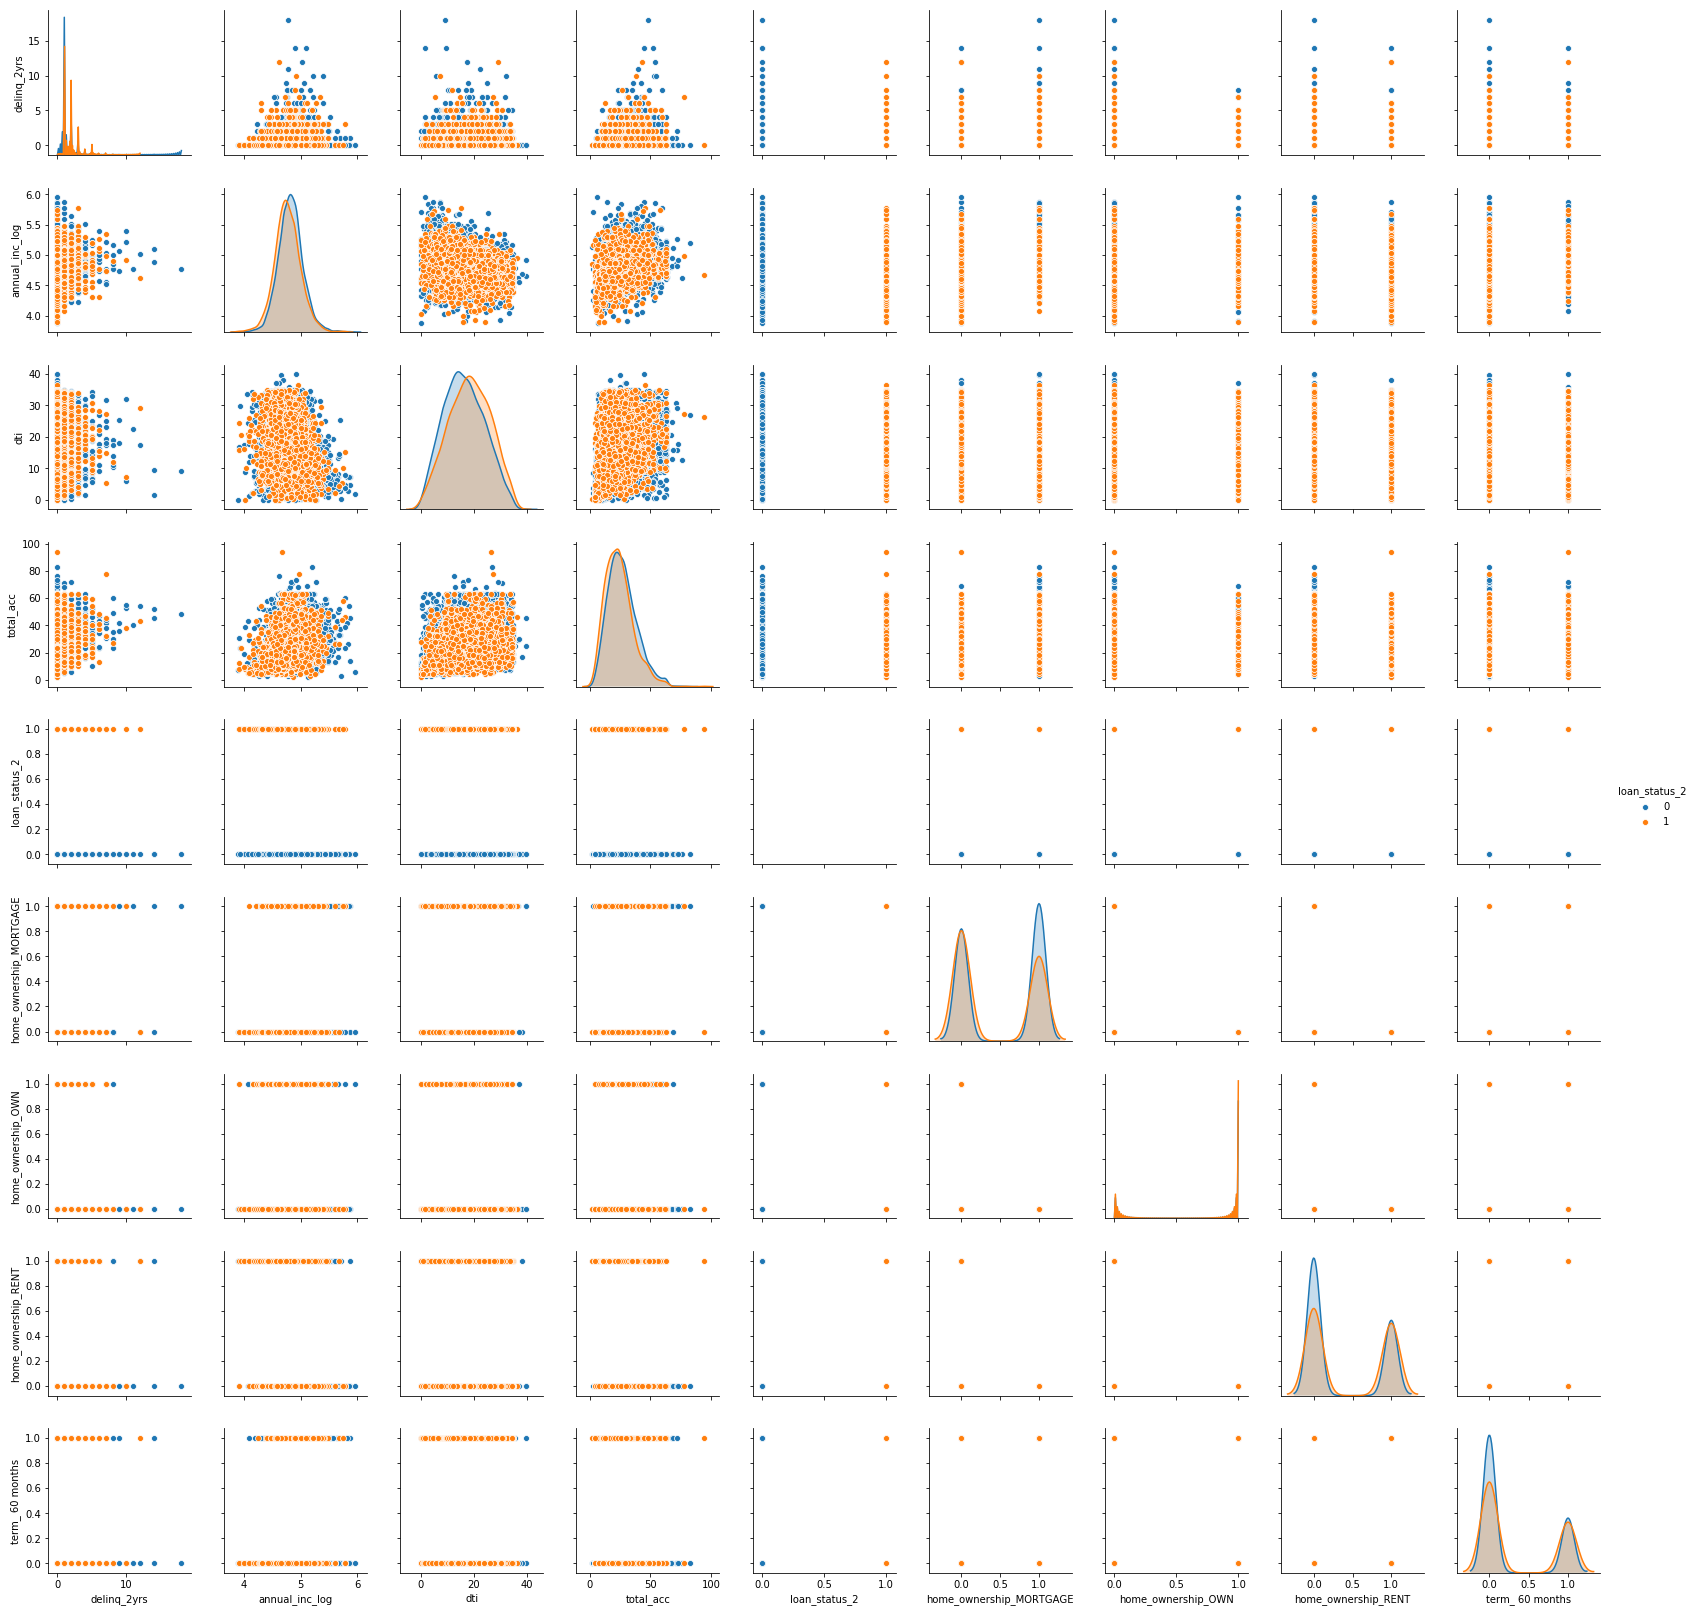

In [122]:
sns.pairplot(lab_rawlog_dum,hue='loan_status_2')

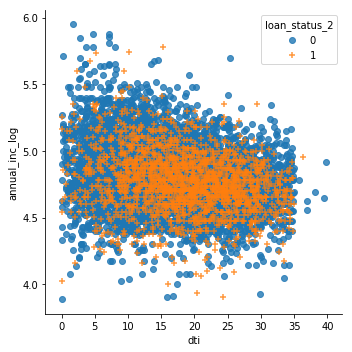

In [171]:
iii=sns.lmplot('dti','annual_inc_log',data=lab_rawlog_dum_risk,hue='loan_status_2',markers=['o','+'],legend_out=False,fit_reg=False)

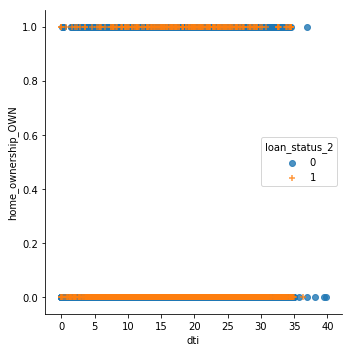

In [172]:
iii=sns.lmplot('dti','home_ownership_OWN',data=lab_rawlog_dum_risk,hue='loan_status_2',markers=['o','+'],legend_out=False,fit_reg=False)

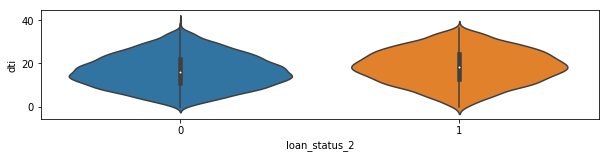

In [146]:
plt.subplots(figsize=(10,2))
iii=sns.violinplot('loan_status_2','dti',data=lab_rawlog_dum)#hue='WnvPresent')

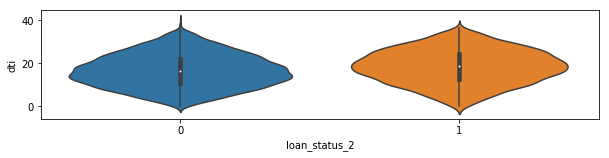

In [145]:
plt.subplots(figsize=(10,2))
iii=sns.violinplot('loan_status_2','dti',data=lab_rawlog_dum_risk)#hue='WnvPresent')

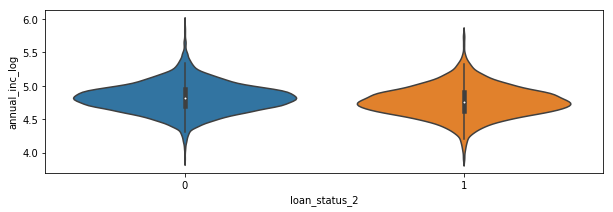

In [149]:
plt.subplots(figsize=(10,3))
iii=sns.violinplot('loan_status_2','annual_inc_log',data=lab_rawlog_dum)#hue='WnvPresent')

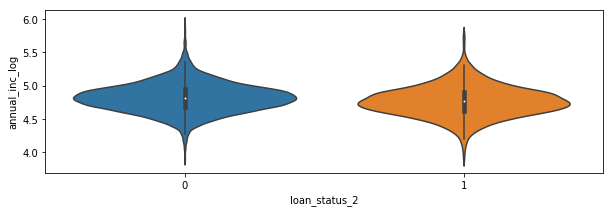

In [132]:
plt.subplots(figsize=(10,3))
iii=sns.violinplot('loan_status_2','annual_inc_log',data=lab_rawlog_dum_risk)#hue='WnvPresent')

Project Plan:
    
1 EDA on important features
- zip* 
2. potential features to engineer:
    - job title 
    
    - purpose loan 
    - 
Be careful of
3. target_linked features
 - revol_bal
- revol_util!
4. temporal leak
- when a predictor comes later in time than what it should predict

Biz Questions:
it would have been useful to have this info:
time of default? because of external factors (economy)
amount of the loan that wasn't reimbursed?'
predicting severity of default? regression ( investigate total_pymnt) 
Do I have info on ratio payment over income? 

processing
- * zip code is difficult ( just 3 digits) - for the next data scientist: enrich with census (translate zip to socio-economic)
- 

features that could be important (from research) 
- interest rate ( because credit score, or because of more ...) -	(this may be because of the highest monthly repayment, and could also arise from the correct assessment by the lender at the beginning of the application).
- Term 
- grade
- dti
- purpose of loan (small business)
- check description (NLP) - mention that if I had more time I would check (bills)
- Engineered: income / interest rate 

investigate the terms: principal + int